In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U sentence-transformers > /dev/null

In [3]:
!ls 'drive/MyDrive/Colab Notebooks/nlp/clustering kpa'

data  KPA_clustering_fine-tunning.ipynb  KPA_clustering.ipynb


In [4]:
import json
import sklearn
import sklearn.model_selection
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

In [5]:
random_state = 321

# Train/Dev/Test split

In [6]:
test_df = pd.read_pickle('drive/MyDrive/Colab Notebooks/nlp/clustering kpa/data/arguments_test_encoded.pkl')
dev_df = pd.read_pickle('drive/MyDrive/Colab Notebooks/nlp/clustering kpa/data/arguments_dev_encoded.pkl')

#TSNE

In [7]:
model_tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500, random_state=random_state)
tsne = model_tsne.fit_transform(dev_df['embedding'].tolist())
dev_df['tsne_30_x'] = tsne[:,0]
dev_df['tsne_30_y'] = tsne[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


# Clustering

In [8]:
# embedder = SentenceTransformer('distiluse-base-multilingual-cased-v2')  
def agglomerative_clustering(corpus, n_clusters, distance_threshold):
    corpus_embeddings = corpus['embedding'].tolist()
    # Normalize the embeddings to unit length
    corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, distance_threshold=distance_threshold)#affinity='cosine', linkage='average', distance_threshold=0.4)
    clustering_model.fit_predict(corpus_embeddings)
    cluster_assignment = clustering_model.labels_
    clustered_sentences = {}
    clustered_embedding = {}
    for sentence_id, cluster_id in enumerate(cluster_assignment):
        if cluster_id not in clustered_sentences:
            clustered_sentences[cluster_id] = []
        clustered_sentences[cluster_id].append(corpus['argument'][sentence_id])
    
    df = pd.DataFrame({"cluster_id": clustered_sentences.keys(), "argument": clustered_sentences.values()})
    return df

In [9]:
def calc_metrics(df,clustered_df,verbose=False):
  # sums up previous notebook's unk clustering 

  merged_df = pd.merge(df,clustered_df.explode('argument'),how='left', left_on=['argument'], right_on = ['argument'])
  assert len(df) == len(clustered_df.explode('argument'))
  aux_df = merged_df.groupby(['cluster_id','topic']).count()['arg_id']
  topics = []
  for cluster_id in range(len(clustered_df)):
    topics.append(aux_df[cluster_id][:].idxmax())
  cluster_id_topic_series = pd.Series(index = np.arange(len(clustered_df)), data = topics)
  topic_cluster_id_series = pd.Series(data = np.arange(len(clustered_df)), index = topics)
  merged_df['topic_matches_cluster'] = merged_df.apply(lambda x: x['topic']==cluster_id_topic_series.loc[x['cluster_id']],axis=1)
  merged_df['pred_topic'] = merged_df['cluster_id'].apply(lambda x: cluster_id_topic_series.loc[x])

  confusion_matrix = pd.crosstab(merged_df['topic'],merged_df['pred_topic'], rownames=['Actual'],colnames=['Predicted'])
  # in case predicted amount does not match actual amount e.g. no predictions for one actual topic
  for index in confusion_matrix.index:
    if index not in confusion_matrix.columns:
      confusion_matrix[index] = 0
  confusion_matrix = confusion_matrix[confusion_matrix.index]
  confusion_matrix_np = confusion_matrix.to_numpy()

  true_pos = np.diag(confusion_matrix_np)
  false_pos = np.sum(confusion_matrix_np, axis=1) - true_pos
  false_neg = np.sum(confusion_matrix_np, axis=0) - true_pos
  precision = true_pos / (true_pos + false_pos)
  recall = true_pos / (true_pos + false_neg)

  m_precision = precision.mean()
  m_recall = recall.mean()
  m_f1 = 2*m_precision*m_recall/(m_precision+m_recall)

  if verbose:
    print(f"True positives: {true_pos}")
    print(f"Fasle positives: {false_pos}")
    print(f"False negatives: {false_neg}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Macroaverage precision {m_precision}")
    print(f"Macroaverage recall {m_recall}")
    print(f"Macroaverage f1 {m_f1}")

  return m_f1, merged_df

# Unk clusters amount

### Check calc_metrics's results to match the previous notebook

In [10]:
%%time
clustered_df = agglomerative_clustering(dev_df, n_clusters=None,distance_threshold=5.0)
calc_metrics(dev_df, clustered_df, verbose=True)

True positives: [236 229 234 193]
Fasle positives: [ 2  4  0 34]
False negatives: [ 0  0 40  0]
Precision: [0.99159664 0.98283262 1.         0.85022026]
Recall: [1.        1.        0.8540146 1.       ]
Macroaverage precision 0.9561623802495984
Macroaverage recall 0.9635036496350364
Macroaverage f1 0.9598189775432724
CPU times: user 230 ms, sys: 8.03 ms, total: 238 ms
Wall time: 258 ms


In [11]:
distance_threshold_list = np.arange(3.,15.,0.1)
f1_scores = []
class_amount_list = []
for distance_threshold in distance_threshold_list:
  clustered_df = agglomerative_clustering(dev_df, n_clusters=None,distance_threshold=distance_threshold)
  class_amount_list.append(len(clustered_df))
  f1_scores.append(calc_metrics(dev_df, clustered_df, verbose=False)[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7

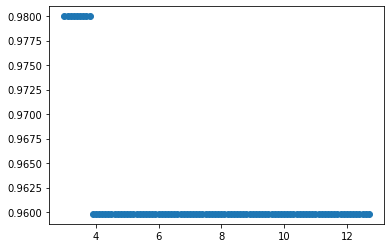

In [12]:
plt.scatter(distance_threshold_list,f1_scores)

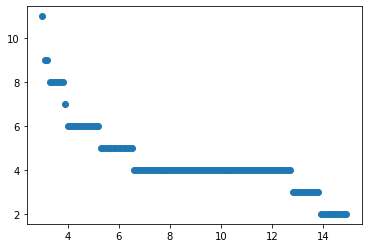

In [13]:
plt.scatter(distance_threshold_list,class_amount_list)

In [14]:
clustered_df = agglomerative_clustering(dev_df, n_clusters=None,distance_threshold=10.0)
f1,merged_df = calc_metrics(dev_df, clustered_df, verbose=True)

True positives: [236 229 234 193]
Fasle positives: [ 2  4  0 34]
False negatives: [ 0  0 40  0]
Precision: [0.99159664 0.98283262 1.         0.85022026]
Recall: [1.        1.        0.8540146 1.       ]
Macroaverage precision 0.9561623802495984
Macroaverage recall 0.9635036496350364
Macroaverage f1 0.9598189775432724


In [15]:
merged_df.head(2)

,arg_id,argument,topic,stance,embedding,tsne_30_x,tsne_30_y,cluster_id,topic_matches_cluster,pred_topic
0,arg_4_0,having a school uniform can reduce bullying as...,We should abandon the use of school uniform,-1,"[-0.01057777, 0.15846351, 0.07416532, -0.05703...",40.296482,-14.603050,3,True,We should abandon the use of school uniform
1,arg_4_1,it is a good way to instill discipline,We should abandon the use of school uniform,-1,"[0.017484298, 0.096222796, 0.011364501, 0.0203...",-30.829950,13.742941,0,False,We should adopt an austerity regime


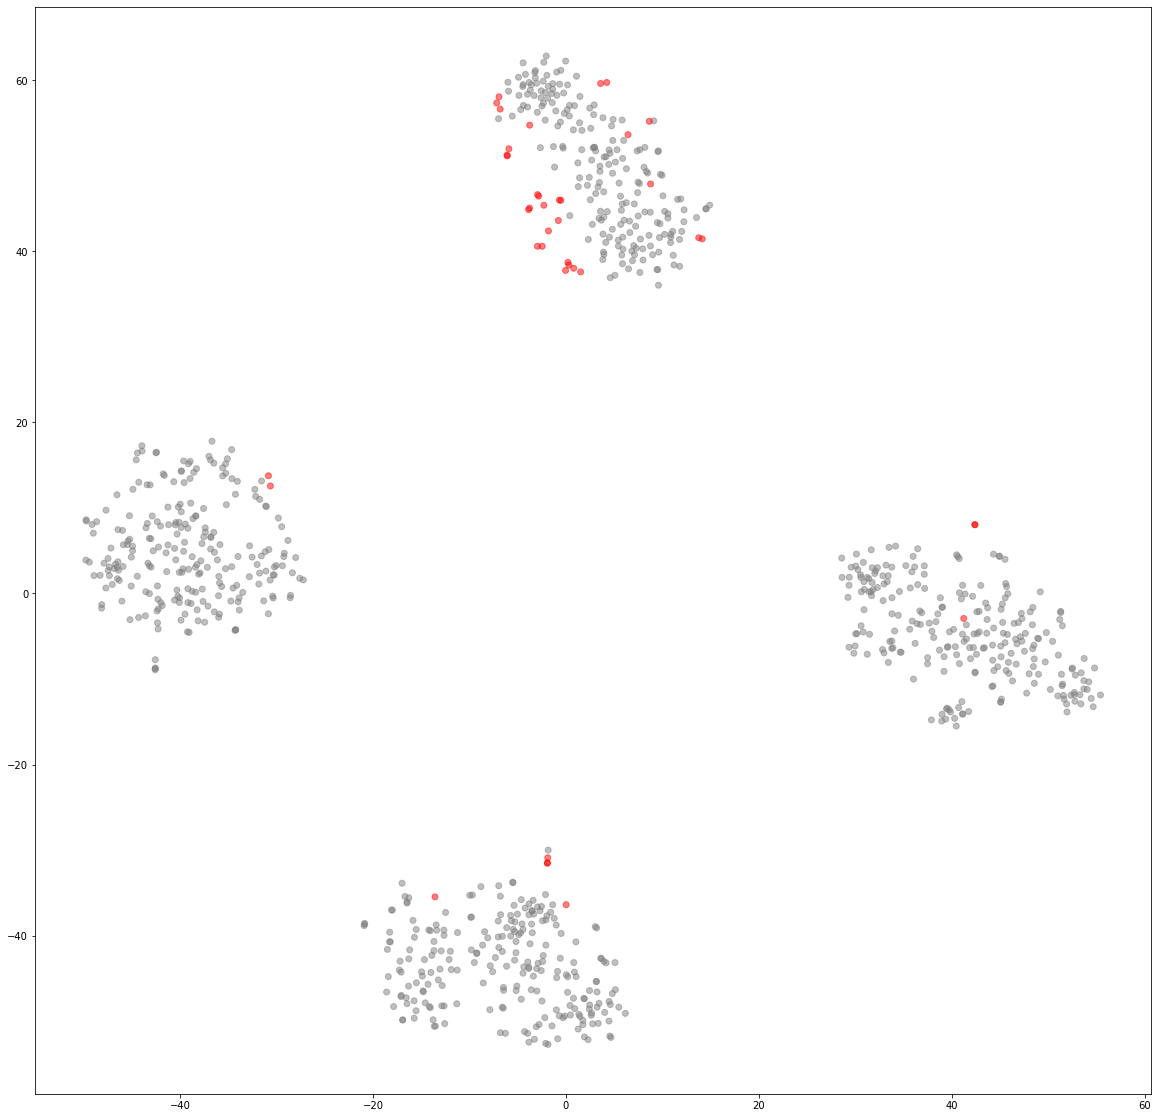

In [16]:
import matplotlib.colors as clrs

cmap = clrs.ListedColormap(['red', 'gray'])

plt.figure(figsize=(20, 20))
plt.scatter(merged_df['tsne_30_x'], merged_df['tsne_30_y'], c = (merged_df['topic_matches_cluster']==True), alpha=.5, cmap=cmap)

# Eval on test set

### TSNE

In [17]:
tsne = model_tsne.fit_transform(test_df['embedding'].tolist())
test_df['tsne_30_x'] = tsne[:,0]
test_df['tsne_30_y'] = tsne[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [18]:
%%time
clustered_df = agglomerative_clustering(test_df, n_clusters=None,distance_threshold=10.0)
f1,merged_df = calc_metrics(test_df, clustered_df, verbose=True)

True positives: [273 232 203]
Fasle positives: [7 1 7]
False negatives: [ 2 13  0]
Precision: [0.975      0.99570815 0.96666667]
Recall: [0.99272727 0.94693878 1.        ]
Macroaverage precision 0.9791249403910348
Macroaverage recall 0.9798886827458256
Macroaverage f1 0.9795066626918789
CPU times: user 204 ms, sys: 2.95 ms, total: 207 ms
Wall time: 263 ms


In [19]:
merged_df.head(2)

,arg_id,argument,topic,stance,embedding,tsne_30_x,tsne_30_y,cluster_id,topic_matches_cluster,pred_topic
0,arg_0_0,Routine child vaccinations isn't mandatory sin...,Routine child vaccinations should be mandatory,-1,"[0.01180115, 0.040217243, 0.016415514, -0.0091...",30.182753,-0.840252,0,True,Routine child vaccinations should be mandatory
1,arg_0_1,Routine child vaccinations should not be manda...,Routine child vaccinations should be mandatory,-1,"[-0.010956358, 0.062280614, 0.02323826, -0.042...",36.057041,2.403170,0,True,Routine child vaccinations should be mandatory


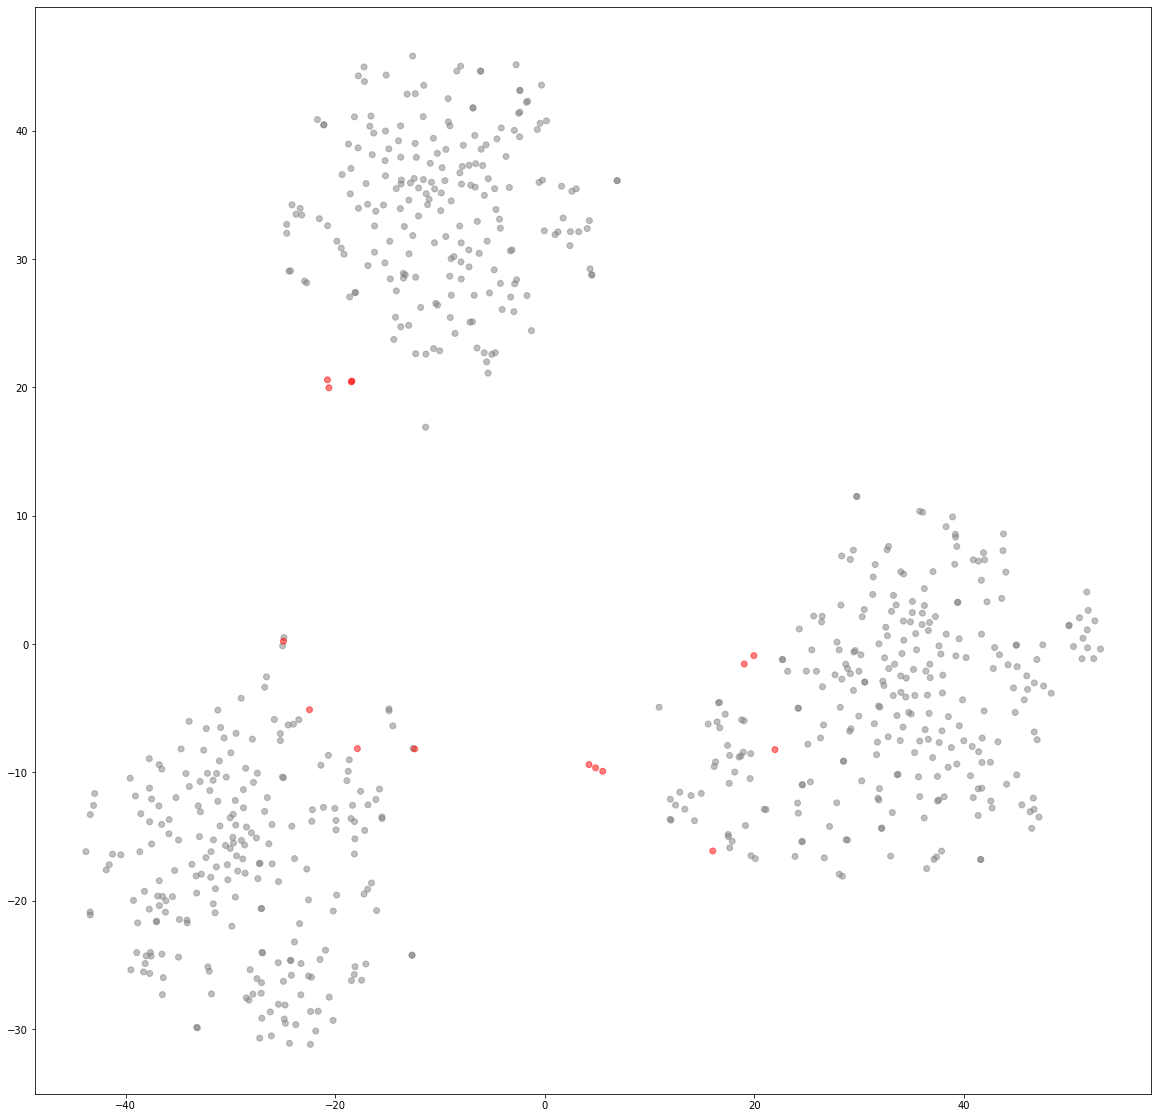

In [20]:
import matplotlib.colors as clrs

cmap = clrs.ListedColormap(['red', 'gray'])

plt.figure(figsize=(20, 20))
plt.scatter(merged_df['tsne_30_x'], merged_df['tsne_30_y'], c = (merged_df['topic_matches_cluster']==True), alpha=.5, cmap=cmap)